In [23]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kusalbera","key":"53ccbf04507c36fc0fcded36e130e70c"}'}

In [24]:
!ls -lha kaggle.json


-rw-r--r-- 1 root root 65 May 30 06:45 kaggle.json


In [25]:
!pip install -q kaggle

In [26]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [27]:
!chmod 600 ~/.kaggle/kaggle.json

In [29]:
!kaggle competitions download -c vsb-power-line-fault-detection

100% 9.99G/10.0G [03:41<00:00, 56.9MB/s]
100% 10.0G/10.0G [03:41<00:00, 48.5MB/s]


In [30]:
!unzip /content/vsb-power-line-fault-detection.zip

Archive:  /content/vsb-power-line-fault-detection.zip
  inflating: metadata_test.csv       
  inflating: metadata_train.csv      
  inflating: sample_submission.csv   
  inflating: test.parquet            
  inflating: train.parquet           


In [109]:
from sklearn.metrics import matthews_corrcoef

In [2]:
!pip install siml


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for siml: filename=siml-0.4.0-py3-none-any.whl size=13726 sha256=49e0f5c5ec184a6fd2725f9f6848d5772dca4d9c9f8f51351e6da904aeb22423
  Stored in directory: /root/.cache/pip/wheels/78/4a/0b/6d7bfb04dad3de613c870498a7c0132aee2a863b5796a4c10c
Successfully built siml


In [83]:
#data structures
import pandas as pd
import pyarrow.parquet as pq
import numpy as np


#used for plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#used for feature engineering(signal processing tools)
from scipy.fftpack import fft
from scipy.signal import welch
from siml.sk_utils import *
from siml.signal_analysis_utils import *

from tqdm import tqdm
import ast

import warnings
warnings.filterwarnings('ignore')

In [84]:
#data structures
import pandas as pd
import numpy as np

from keras.layers import *
from keras.models import *
from keras import backend as K # The backend gives us access to tensorflow operations and allow us to create attention class
from keras import optimizers # Allows to access Adam class and modify some parameters
from keras.callbacks import * # This object helps the model to train in a smarter way, avoid overfitting
from keras import activations
from keras import regularizers
from keras import initializers
from keras import constraints
from tensorflow.keras.layers import Attention,LSTM,GRU
from keras.utils.vis_utils import plot_model
import tensorflow.compat.v1 as tf

# https://stackoverflow.com/a/56569206/4699076
tf.disable_eager_execution()

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split


import concurrent.futures
import multiprocessing

In [85]:
# Matthews correlation coefficient calculation used inside Keras model
def matthews_correlation(y_true, y_pred):
  """
  Calculate Matthews Correlation Coefficient.

  References
  ----------
  .. [1] https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
  .. [2] https://www.kaggle.com/tarunpaparaju/vsb-competition-attention-bilstm-with-features/notebook?scriptVersionId=10690570
  """
  y_pred_positive = K.round(K.clip(y_pred, 0, 1))
  y_pred_negative = 1 - y_pred_positive 

  y_positive = K.round(K.clip(y_true, 0, 1))
  y_negative= 1 - y_positive

  tp = K.sum(y_positive * y_pred_positive)
  tn = K.sum(y_negative * y_pred_negative)

  fp = K.sum(y_negative * y_pred_positive)
  fn = K.sum(y_positive * y_pred_negative)

  numerator = (tp * tn - fp * fn)
  denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

  return numerator / (denominator + K.epsilon())

In [86]:
from sklearn.metrics import confusion_matrix
def custom_confusion_matrix(y_test,y_test_pred):
    
    con_mat_test=confusion_matrix(y_test,y_test_pred)
    print(con_mat_test)
    con_mat_test_df = pd.DataFrame(con_mat_test, range(2),range(2))


    symbol=np.asarray(['TN','FP','FN','TP',]).reshape(2,2)
    symbol_df=pd.DataFrame(symbol)

    labels=(np.asarray(["{0} = {1}".format(symb,value)
                   for symb,value in zip(symbol.flatten(),
                                        con_mat_test.flatten())])).reshape(2,2)


    sns.heatmap(con_mat_test_df, annot=labels,annot_kws={"size": 16}, fmt='')
    ax= plt.subplot();



    ax.set_ylim(2.0, 0)
    ax.set_title('Confusion Matrix on Test data');
    ax.xaxis.set_ticklabels(['Predicted : 0','Predicted : 1']); 
    ax.yaxis.set_ticklabels(['Actual : 0','Actual : 1']);

In [87]:
max_num = 127
min_num = -128

In [88]:
# This function standardize the data from (-128 to 127) to (-1 to 1)
# Theoretically it helps in the NN Model training, but I didn't tested without it
def standardize_data(signal, min_data, max_data, range_needed=(-1,1)):
    if min_data < 0:
        signal_std = (signal + abs(min_data)) / (max_data + abs(min_data))
    else:
        signal_std = (signal - min_data) / (max_data - min_data)
    if range_needed[0] < 0:    
        return signal_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return signal_std * (range_needed[1] - range_needed[0]) + range_needed[0]

In [89]:
# This is one of the most important peace of code of this Kernel
# Any power line contain 3 phases of 800000 measurements, or 2.4 millions data 
# It would be praticaly impossible to build a NN with an input of that size
# The ideia here is to reduce it each phase to a matrix of <n_dim> bins by n features
# Each bean is a set of 5000 measurements (800000 / 160), so the features are extracted from this 5000 chunk data.
def transform_signal(signal, n_dim=160, min_max=(-1,1)):
    # convert data into -1 to 1
    signal_std = standardize_data(signal, min_data=min_num, max_data=max_num)
    # bucket or chunk size, 5000 in this case (800000 / 160)
    bucket_size = int(800000  / n_dim)
    # new_ts will be the container of the new data
    new_signal = []
    # this for iteract any chunk/bucket until reach the whole sample_size (800000)
    for i in range(0, 800000 , bucket_size):
        # cut each bucket to ts_range
        signal_range = signal_std[i:i + bucket_size]
        # calculate each feature
        mean = signal_range.mean()
        std = signal_range.std() # standard deviation
        std_top = mean + std # I have to test it more, but is is like a band
        std_bot = mean - std
        # I think that the percentiles are very important, it is like a distribuiton analysis from eath chunk
        percentil_calc = np.percentile(signal_range, [0, 1, 25, 50, 75, 99, 100]) 
        max_range = percentil_calc[-1] - percentil_calc[0] # this is the amplitude of the chunk
        relative_percentile = percentil_calc - mean # maybe it could heap to understand the asymmetry
        # now, we just add all the features to new_ts and convert it to np.array
        new_signal.append(np.concatenate([np.asarray([mean, std, std_top, std_bot, max_range]),percentil_calc, relative_percentile]))
    return np.asarray(new_signal)

In [90]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,kernel_initializer=None,
                 kernel_regularizer=None, bias_regularizer=None,
                 kernel_constraint=None, bias_constraint=None,
                 use_bias=True, **kwargs):
        
        self.kernel_initializer = initializers.get('glorot_uniform')
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint= constraints.get(bias_constraint)

        self.use_bias = use_bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
    
    def get_config(self):
        config = super().get_config()
        config['kernel_initializer']=self.kernel_initializer
        config["kernel_regularizer"]=self.kernel_regularizer
        config["bias_regularizer"]=self.bias_regularizer
        config["kernel_constraint"]=self.kernel_constraint

        config["bias_constraint"]=self.bias_constraint 
        config["use_bias"]=self.use_bias
        config["step_dim"]=self.step_dim 
        config["features_dim "]=self.features_dim
        
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.kernel = self.add_weight(shape=(input_shape[-1],),
                                 name='{}_kernel'.format(self.name),
                                 regularizer=self.kernel_regularizer,
                                 constraint=self.kernel_constraint)
        self.features_dim = input_shape[-1]

        if self.use_bias:
            self.bias = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_bias'.format(self.name),
                                     regularizer=self.bias_regularizer,
                                     constraint=self.bias_constraint)
        else:
            self.bias = None

        self.built = True


    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.kernel, (features_dim, 1))), (-1, step_dim))

        if self.use_bias:
            eij += self.bias

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim



In [116]:
import keras
from keras.models import load_model

from keras.initializers import glorot_uniform

In [117]:
meta_data=pd.read_csv("df_metadata_sample.csv")

In [118]:
signal_data=pq.read_pandas('sample_signal_data.parquet',columns=[str(i) for i in range(3)]).to_pandas()

In [119]:
def data_processing(meta_data,signal_data):
    meta_data=pd.read_csv("df_metadata_sample.csv")
    first_sig = meta_data.index[0]
    n_parts = 3
    max_line = len(meta_data)
    part_size = int(max_line / n_parts)
    start_end = [[x, x+part_size] for x in range(first_sig, max_line + first_sig, part_size)]
    start_end = start_end[:-1] + [[start_end[-1][0], start_end[-1][0]+3]]

    X_test = []

    for start, end in start_end:
        signal_data = pq.read_pandas('sample_signal_data.parquet', columns=[str(i) for i in range(start, end)]).to_pandas()
        for i in tqdm(signal_data.columns):
            id_measurement, phase = meta_data.loc[int(i)]
            subset_test_col = signal_data[i]
            subset_trans = transform_signal(subset_test_col)
            X_test.append([i, id_measurement, phase, subset_trans])
            
    x_test=np.asarray([np.concatenate([X_test[i][3],X_test[i+1][3], X_test[i+2][3]], axis=1) for i in range(0,len(X_test), 3)])
    return x_test

In [120]:
def final_fun_1(signal_data,meta_data,step_dim):
    '''
    returns the prediction for raw input
    '''
    X_test=[]
    for i in tqdm(signal_data.columns):
        id_measurement, phase = meta_data.loc[int(i)]
        subset_test_col = signal_data[i]
        subset_trans = transform_signal(subset_test_col)
        X_test.append([i, id_measurement, phase, subset_trans])
            
    x_test=np.asarray([np.concatenate([X_test[i][3],X_test[i+1][3], X_test[i+2][3]], axis=1) for i in range(0,len(X_test), 3)])
    
    clf = load_model('model.h5',
                     custom_objects={'Attention': Attention(step_dim),
                                     'GlorotUniform':glorot_uniform
                                     ,'LSTMCell':LSTMCell,
                                     'matthews_correlation':matthews_correlation})
    pred = clf.predict(x_test)
    
    if pred>0.5:
        y_pred=1
    else:
        y_pred=0
    
    return y_pred

In [122]:
step_dim=160
y_pred=print("predicted class is:",final_fun_1(signal_data,meta_data,step_dim))

100%|██████████| 3/3 [00:00<00:00,  6.37it/s]

predicted class is: 0


In [92]:
meta_data=pd.read_csv("/content/metadata_train.csv")



In [114]:
def final_fun_2(meta_data,step_dim):
    '''
    returns the matthews correlation score for raw input
    '''

    meta_data=pd.read_csv("/content/metadata_train.csv")
    meta_data=meta_data.set_index(['id_measurement', 'phase'])
    y = []
    for id_measurement in tqdm(meta_data.index.levels[0].unique()[0:int(len(meta_data)/3)]):
        X_signal = []
        for phase in [0,1,2]:
            signal_id, target = meta_data.loc[id_measurement].loc[phase]
            if phase == 0:
                y.append(target)
    y=np.asarray(y)
    meta_data=meta_data.drop(['target'], axis = 1)
    meta_data=meta_data.reset_index()
    meta_data = meta_data.set_index(['signal_id'])

    first_sig = meta_data.index[0]
    n_parts = 10
    max_line = len(meta_data)
    part_size = int(max_line / n_parts)
    last_part = max_line % n_parts
    start_end = [[x, x+part_size] for x in range(first_sig, max_line + first_sig, part_size)]
    start_end = start_end[:-1] + [[start_end[-1][0], start_end[-1][0] + last_part]]

    X_test = []

    for start, end in start_end:
        signal_data = pq.read_pandas('/content/train.parquet', columns=[str(i) for i in range(start, end)]).to_pandas()
        for i in tqdm(signal_data.columns):
            id_measurement, phase = meta_data.loc[int(i)]
            subset_test_col = signal_data[i]
            subset_trans = transform_signal(subset_test_col)
            X_test.append([i, id_measurement, phase, subset_trans])
            
    X=np.asarray([np.concatenate([X_test[i][3],X_test[i+1][3], X_test[i+2][3]], axis=1) for i in range(0,len(X_test), 3)])
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y,random_state=42)
    clf = load_model('model.h5',
                     custom_objects={'Attention': Attention(step_dim),
                                     'GlorotUniform':glorot_uniform
                                     ,'LSTMCell':LSTMCell,
                                     'matthews_correlation':matthews_correlation})
    
    pred = clf.predict(X_test)
  
    best_threshold = 0
    best_score = 0
    thresh_arr = np.linspace(0, 0.99, 100)

    y_val = y_test

    for thresh in thresh_arr:
        y_pred = (pred > thresh).astype(np.int).flatten()
        score = matthews_corrcoef(y_val,y_pred)
        if score > best_score:
            best_threshold = thresh
            best_score = score


    y_pred = (pred > best_threshold).astype(np.int).flatten()
    return best_score,custom_confusion_matrix(y_test,y_pred)
  

100%|██████████| 2/2 [00:00<00:00, 12.59it/s]


[[790  29]
 [ 10  43]]
matthews correlation score on test data (0.6735672384862607, None)


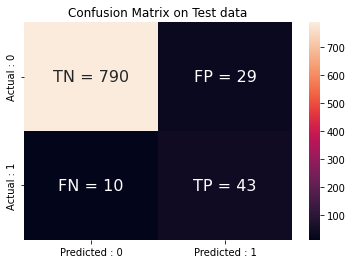

In [115]:
step_dim=160
matthews_correlation_score=print("matthews correlation score on test data",final_fun_2(meta_data,step_dim))